<a href="https://colab.research.google.com/github/Henry-Os/Crop-monitoring-using-Sentinel-1-and-2/blob/master/S2_VIs_cal_SAR_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
#!pip install virtualenv
#!virtualenv /content/drive/MyDrive/my_env
#!source /content/drive/MyDrive/my_env/bin/activate; pip install package_name
os.chdir("/content/drive/MyDrive/my_env/lib/python3.10/site-packages")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector, ExhaustiveFeatureSelector
from sklearn.feature_selection import SelectFromModel
import seaborn as sns


# turns on 'nline plotting', where plot graphics will appear in the notebook below the cell that produced them.
%matplotlib inline

# Change module setting
pd.options.display.max_colwidth = 80       # Longer text in pd.df

In [ ]:
root_path= '/content/drive/My Drive/'
os.chdir(root_path)

# Objective 1: Calibrates SAR polarimetric parameters against optical vegetation indices

## Data Cleaning and Munging

In [ ]:
# reads the corn plots
plots= gpd.read_file('2023_plots/plots.shp')


# reads the SAR_optical pairs for each growing period
early_july= rasterio.open('SAR_optical/July/Early_July/16_5_stacked.tif')
late_july= rasterio.open('SAR_optical/July/Late_July/16_5_stacked.tif')
august= rasterio.open('SAR_optical/August/16_5_stacked.tif')
september= rasterio.open('SAR_optical/September/16_5_stacked.tif')

# puts them in a list for looping
all_4= [early_july.read(), late_july.read(), august.read(), september.read()]

# Transforms pixel coordinates to x,y coordinaetes
affine= late_july.transform

In [ ]:
# column names for separating the monthly data into separate dataframes and appending them row-wise
names= ['S1_ELLIP', 'S1_ORIEN', 'S1_LPR', 'S1_I2', 'S1_I1', 'S1_g3', 'S1_g2', 'S1_g1', 'S1_g0', 'S1_DoLP',
            'S1_span', 'S1_entropy_shannon', 'S1_entropy', 'S1_alpha', 'S1_C22', 'S1_C11', 'S2_NDVI', 'S2_NDRE', 'S2_NDWI', 'S2_RECI', 'S2_GCI']

# creates special column names for each month's data
el= [name + '_el' for name in names]
ll= [name + '_ll' for name in names]
au= [name + '_au' for name in names]
se= [name + '_se' for name in names]

# unpacks the names in the above lists into a new list
all_names= [*el , *ll , *au ,*se]


# column names for final training data
new_names= ['Id', 'Name', 'geometry', 'S1_ELLIP', 'S1_ORIEN', 'S1_LPR', 'S1_I2', 'S1_I1', 'S1_g3', 'S1_g2', 'S1_g1', 'S1_g0', 'S1_DoLP',
            'S1_span', 'S1_entropy_shannon', 'S1_entropy', 'S1_alpha', 'S1_C22', 'S1_C11', 'S2_NDVI', 'S2_NDRE', 'S2_NDWI', 'S2_RECI', 'S2_GCI']

In [ ]:
# finds the mean of each plot for all the 21 features
mean= []
for each in all_4:
    for band in each:
        df_mean = pd.DataFrame(zonal_stats(plots, band, affine=affine, stats= 'mean'))
        mean.append(df_mean)

# the result of the above cells is a dataframe for each feature for each month, so this line of code appends them
mean_df= pd.concat(mean, axis=1)

# renames the columns and splits tyhem based on the growing stage
mean_df.columns= all_names
mean_el= mean_df.filter(like= '_el')
mean_ll= mean_df.filter(like= '_ll')
mean_au= mean_df.filter(like= '_au')
mean_se= mean_df.filter(like= '_se')

# adds median statistics of each growing stage to the plots GeoDataFrame for visualization
mean_el_plots = pd.concat([plots, mean_el], axis=1)
mean_ll_plots = pd.concat([plots, mean_ll], axis=1)
mean_au_plots = pd.concat([plots, mean_au], axis=1)
mean_se_plots = pd.concat([plots, mean_se], axis=1)

# renames the columns of all dataframes for row-wise concatenation
mean_el_plots.columns= new_names
mean_ll_plots.columns= new_names
mean_au_plots.columns= new_names
mean_se_plots.columns= new_names

# row-wise concatenation of data from each growing stage
train_pts= pd.concat([mean_el_plots, mean_ll_plots, mean_au_plots, mean_se_plots]).reset_index(drop=True).drop('Id', axis= 1)

# specifies the treatment for each plot
def Treatment_extractor(x):
    return x[0:2]

train_pts['Treatment']= train_pts['Name'].apply(Treatment_extractor)

/content/drive/MyDrive/my_env/lib/python3.10/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [ ]:
# filters the data according to crop crop treatment
#train_pts= train_pts[train_pts['Treatment']!='T4']
train_pts= train_pts[(train_pts['Treatment']=='T1') | (train_pts['Treatment']=='T2')| (train_pts['Treatment']=='T3') | (train_pts['Treatment']=='T4')]

In [ ]:
# filters the data according to growing stage for treatments
#e_july= train_pts.iloc[0:42, :]
#l_july= train_pts.iloc[42:84, :]
#aug= train_pts.iloc[84:126, :]
#sep= train_pts.iloc[126:, :]

# filters the data according to growing stage without T4
#e_july= train_pts.iloc[0:36, :]
#l_july= train_pts.iloc[36:72, :]
#aug= train_pts.iloc[72:108, :]
#sep= train_pts.iloc[108:, :]

# filters the data according to growing stage without T7, 5, and 6
e_july= train_pts.iloc[0:24, :]
l_july= train_pts.iloc[24:48, :]
aug= train_pts.iloc[48:72, :]
sep= train_pts.iloc[72:, :]

## Exploratory Data Analysis

Text(0.5, 1.0, 'Late July NDVI')

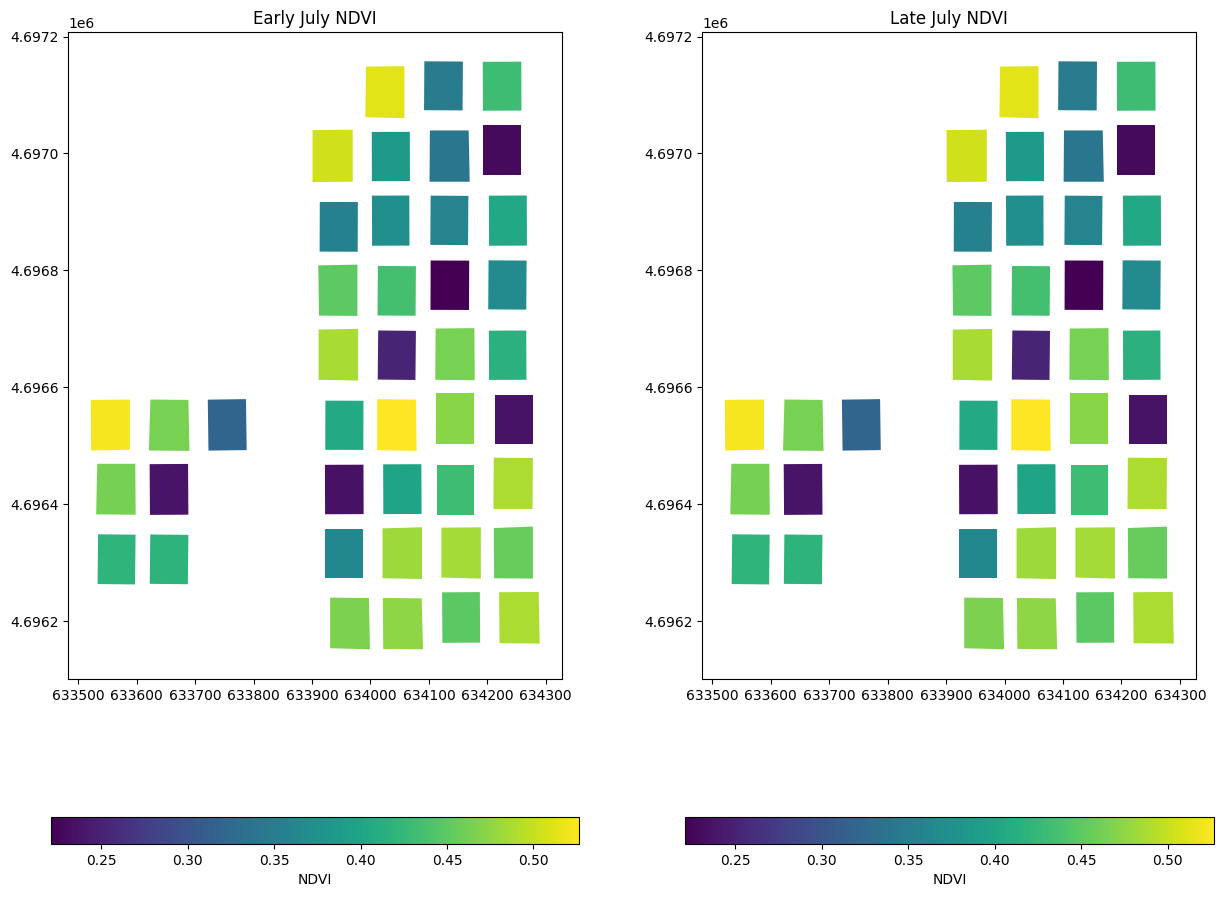

In [ ]:
# plots choropleth maps of NDVI for each plot for each growing stage

# Creates 4 subplots
fig, ax = plt.subplots(nrows= 1, ncols=2, figsize=(15, 12))

# Access each axes object to plot  data
e_july.plot(column= 'S2_NDVI', ax= ax[0], legend= True, legend_kwds= {'label': 'NDVI', 'orientation': 'horizontal'}).set_title('Early July NDVI')

e_july.plot(column= 'S2_NDVI', ax= ax[1], legend= True, legend_kwds= {'label': 'NDVI', 'orientation': 'horizontal'}).set_title('Late July NDVI')

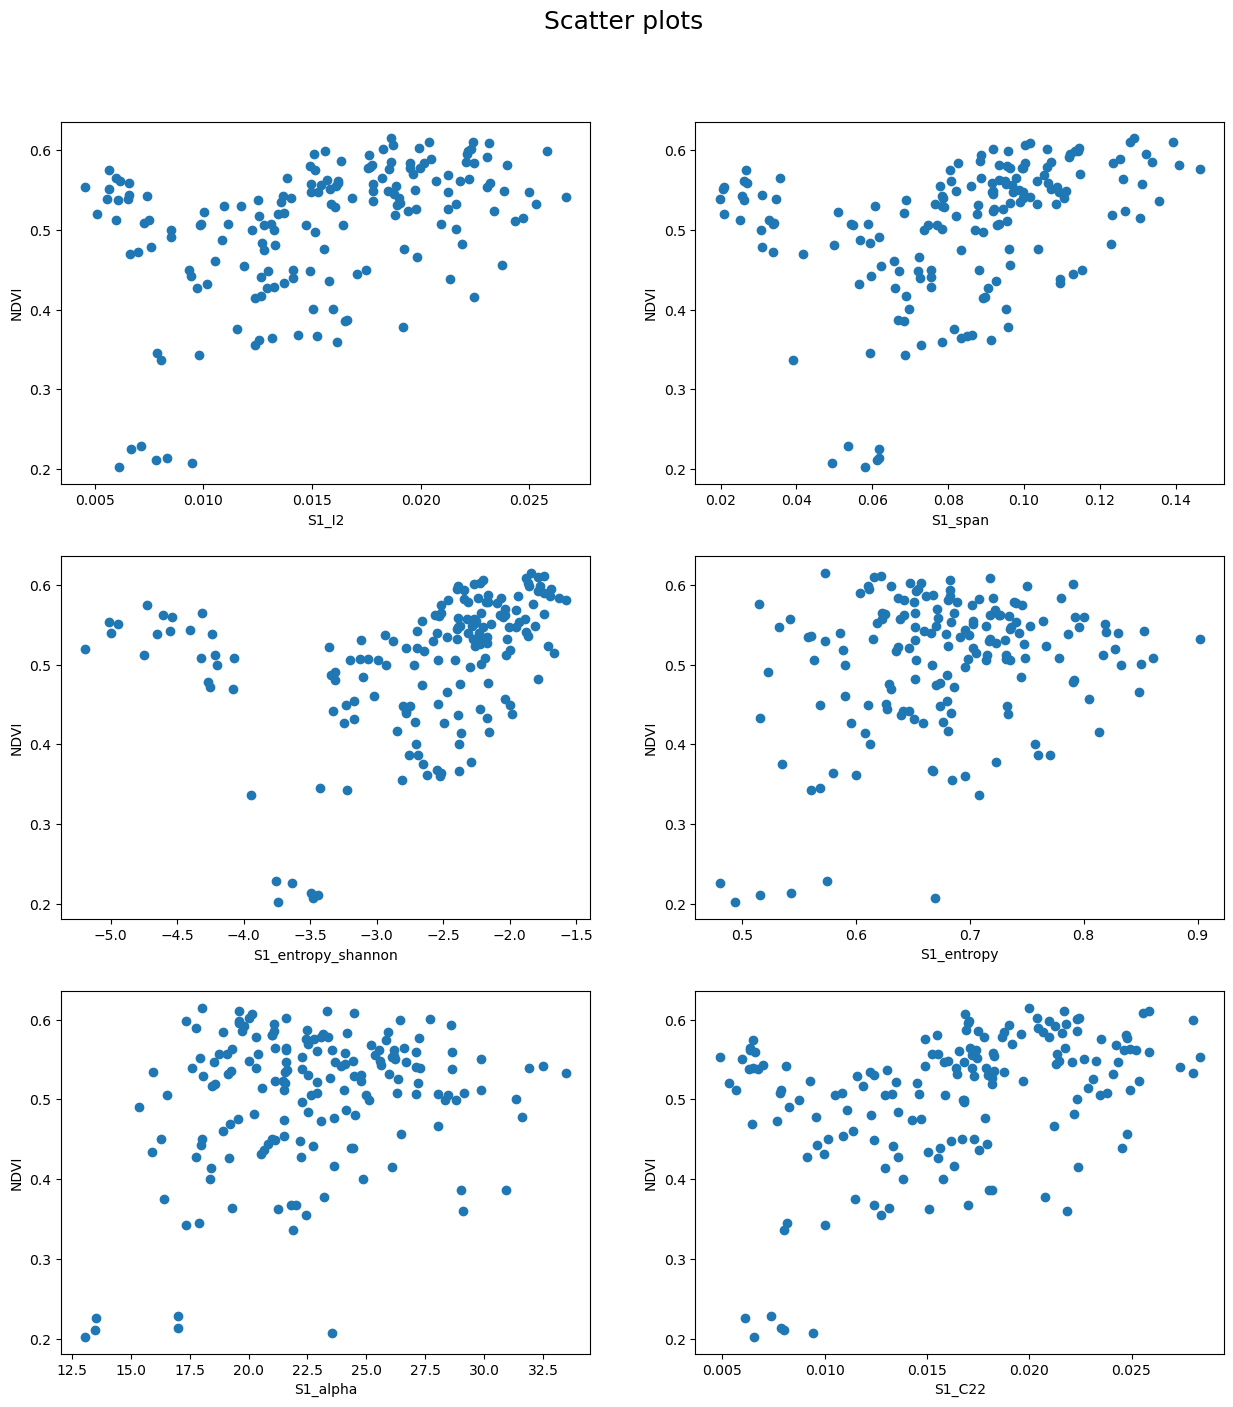

In [ ]:
# selects features of interest for plotting
plotting= train_pts.iloc[:, [5, 12, 13, 14, 15, 16]]

# plots scatter plots of the dependent variables(any of the VIs) with some of the independent variable

# defines the subplots
fig, axs= plt.subplots(nrows=3, ncols=2, figsize= (15, 16))
fig.suptitle('Scatter plots', fontsize=18, y=0.95)

# loops through the variables and subplots
for variable, ax in zip(plotting, axs.ravel()):
    ax.scatter(x= plotting[variable], y= train_pts['S2_NDVI'])

    ax.set_xlabel(variable)
    ax.set_ylabel('NDVI')

## Modeling

### Feature selection

In [ ]:
selected= pd.concat([l_july, e_july, aug]).reset_index()

In [ ]:
# partition features and labels
x= train_pts[['S1_ELLIP', 'S1_ORIEN', 'S1_LPR', 'S1_I2', 'S1_I1', 'S1_g3', 'S1_g2', 'S1_g1', 'S1_g0', 'S1_DoLP',
            'S1_span', 'S1_entropy_shannon', 'S1_entropy', 'S1_alpha', 'S1_C22', 'S1_C11']]

#X= StandardScaler().fit_transform(x)

y= train_pts['S2_NDRE']

### Lasso feature importance

In [ ]:
#lasso_sel = SelectFromModel(Lasso(alpha=0.001, random_state=10))
#lasso_sel.fit(x,y)

In [ ]:
#lasso_sel.get_support()

In [ ]:
#lasso_sel.get_feature_names_out()

In [ ]:
#x_selected= selected[['S1_entropy_shannon', 'S1_g1', 'S1_I2']]

In [ ]:
#scores = cross_val_score(rf, x_selected, y, cv=kf)
#print(scores)
#np.mean(scores)

### Random feature importance

[0.0356472  0.01835328 0.01766761 0.2735833  0.02001916 0.02471808
 0.02680635 0.0244351  0.01572043 0.0114216  0.07007194 0.33002518
 0.02404312 0.02092949 0.06419771 0.02236046]


<function matplotlib.pyplot.show(close=None, block=None)>

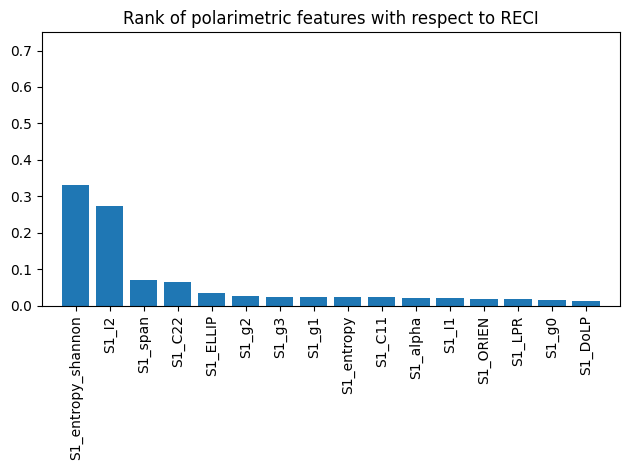

In [ ]:
# initiates model
rf= RandomForestRegressor(random_state=42)
rf.fit(x,y)

# # ranks the features using the random forest (impurity) method
rf_importance= rf.feature_importances_
print(rf_importance)

# plots the importance of features in descending order for SAR data
indices= np.argsort(rf_importance)[::-1]

plt.figure()
plt.title('Rank of polarimetric features with respect to RECI')
plt.bar(range(x.shape[1]), rf_importance[indices])
plt.xticks(range(x.shape[1]), x.iloc[:,:].columns[indices], rotation= 90)
plt.xlim([-1, x.shape[1]])
plt.ylim([0, 0.75])
plt.tight_layout()
plt.show

In [ ]:
kf = KFold(n_splits=5, shuffle= True, random_state= 42)

### Sequential Forward Feature Selection

In [ ]:
# selects the best features using sequential feature selection
SFS2 = SequentialFeatureSelector(rf,
           k_features= 'best',
           forward=True,
           floating=False,
           verbose=0,
           scoring='r2',
           cv=kf)


SFS2 = SFS2.fit(x, y)

In [ ]:
# prints the selected features from mlxtend
x.columns[list(SFS2.k_feature_idx_)]

Index(['S1_g1', 'S1_entropy_shannon'], dtype='object')

In [ ]:
# creates a dataframe of r2 scores from different feature combination
metric_dict = SFS2.get_metric_dict(confidence_interval=0.95)
SFS2_df = pd.DataFrame(metric_dict).T
SFS2_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(11,)","[0.3511922028272473, 0.7868684427462493, 0.5043354218611191, -0.101519149819...",0.427452,"(S1_entropy_shannon,)",0.385268,0.299752,0.149876
2,"(7, 11)","[0.551645274131191, 0.8300391847574208, 0.5685809524998318, -0.0491631272115...",0.52217,"(S1_g1, S1_entropy_shannon)",0.389599,0.303121,0.151561
3,"(7, 10, 11)","[0.6323247932117267, 0.8015653066445183, 0.47721399470351267, -0.00705605957...",0.520254,"(S1_g1, S1_span, S1_entropy_shannon)",0.364861,0.283874,0.141937
4,"(3, 7, 10, 11)","[0.5912079948806847, 0.8274616528024104, 0.46336929020951245, -0.03999396396...",0.519717,"(S1_I2, S1_g1, S1_span, S1_entropy_shannon)",0.395049,0.307361,0.153681
5,"(3, 7, 10, 11, 15)","[0.5879655592752403, 0.822997969152066, 0.43061756084313607, -0.071339681863...",0.501863,"(S1_I2, S1_g1, S1_span, S1_entropy_shannon, S1_C11)",0.406626,0.316369,0.158185
6,"(3, 7, 8, 10, 11, 15)","[0.5979345104188362, 0.8283220422102522, 0.4366737881371273, -0.147382967573...",0.488156,"(S1_I2, S1_g1, S1_g0, S1_span, S1_entropy_shannon, S1_C11)",0.44171,0.343666,0.171833
7,"(3, 4, 7, 8, 10, 11, 15)","[0.584348354253585, 0.8267272009271149, 0.43939517050540267, -0.189196185250...",0.474978,"(S1_I2, S1_I1, S1_g1, S1_g0, S1_span, S1_entropy_shannon, S1_C11)",0.458051,0.356379,0.17819
8,"(1, 3, 4, 7, 8, 10, 11, 15)","[0.5466115327510053, 0.8095274346932726, 0.3657577133555222, -0.102740728055...",0.46928,"(S1_ORIEN, S1_I2, S1_I1, S1_g1, S1_g0, S1_span, S1_entropy_shannon, S1_C11)",0.416965,0.324413,0.162206
9,"(1, 2, 3, 4, 7, 8, 10, 11, 15)","[0.5404952041694447, 0.8114963660937785, 0.40799266918845867, -0.17218496999...",0.452302,"(S1_ORIEN, S1_LPR, S1_I2, S1_I1, S1_g1, S1_g0, S1_span, S1_entropy_shannon, ...",0.436911,0.339931,0.169966
10,"(1, 2, 3, 4, 7, 8, 10, 11, 13, 15)","[0.5525229988729127, 0.8034181888763302, 0.39639932492852226, -0.20214134755...",0.440354,"(S1_ORIEN, S1_LPR, S1_I2, S1_I1, S1_g1, S1_g0, S1_span, S1_entropy_shannon, ...",0.446624,0.347489,0.173744
